## Cifar10 with MC-Dropout

In this notebook we will use again the cifar 10 dataset. We will use only 5 of the 10 labels to train a two models, in in the first one we use dropout at training time but not at test. The second model usees dropout not only in the training but also at test-time. The labels for the trainig will be only airplane, automobile, bird, cat and deer but we will predict all ten labels! The goal is find a method to distinglish between known and unknown labels or at least to know which predictions are not certain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf 

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


#### Make train and testset smaller


In [0]:
#loop over each class label and sample random images over each label and save the idx to subset
np.random.seed(seed=220)
idx=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_train))):
    idx=np.append(idx,np.random.choice(np.where((y_train[0:len(y_train)])==i)[0],5000,replace=False))

x_train= x_train[idx]
y_train= y_train[idx]

In [0]:
#loop over each class label and sample random images over each label and save the idx to subset
np.random.seed(seed=220)
idx=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_test))):
    idx=np.append(idx,np.random.choice(np.where((y_test[0:len(y_test)])==i)[0],500,replace=False))

x_test= x_test[idx]
y_test= y_test[idx]

In [5]:
print(x_train.shape)
print(y_train.shape)
print(np.unique(y_train,return_counts=True))
print(x_test.shape)
print(y_test.shape)
print(np.unique(y_test,return_counts=True))

(50000, 32, 32, 3)
(50000, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(5000, 32, 32, 3)
(5000, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))


In [0]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

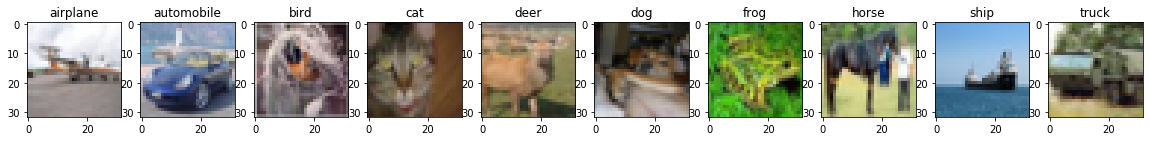

In [7]:
#sample image of each label
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i])

#### Delete all labels, except the first 5

In [0]:
idx=np.where(np.in1d(y_train,[5,6,7,8,9]))[0]
x_train=np.delete(x_train,idx,axis=0)
y_train=np.delete(y_train,idx,axis=0)

In [9]:
x_train=np.delete(x_train,idx,axis=0)
y_train=np.delete(y_train,idx,axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25000, 32, 32, 3)
(25000, 1)
(5000, 32, 32, 3)
(5000, 1)


#### Normalize the train and testdata


In [0]:
X_mean = np.mean( x_train, axis = 0)
X_std = np.std( x_train, axis = 0)

x_train = (x_train - X_mean ) / (X_std + 0.0001)
x_test = (x_test - X_mean ) / (X_std + 0.0001)

In [12]:
print(np.unique(y_train))
labels[np.unique(y_train)]

[0 1 2 3 4]


array(['airplane', 'automobile', 'bird', 'cat', 'deer'], dtype='<U10')

In [0]:
from keras.utils.np_utils import to_categorical   
y_train=to_categorical(y_train,5)

#### Split trainingdata into a tran and validset

In [14]:
#make 80% train and 20% valid out of train
np.random.seed(478)
rand_idx=np.random.choice(list(range(0,len(x_train))),replace=False,size=round(0.8*(len(x_train))))
len(rand_idx)

20000

In [0]:
x_valid=np.delete(x_train,axis=0,obj=rand_idx)
y_valid=np.delete(y_train,axis=0,obj=rand_idx)

In [0]:
x_train=x_train[rand_idx]
y_train=y_train[rand_idx]

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


(20000, 32, 32, 3)
(20000, 5)
(5000, 32, 32, 3)
(5000, 5)


#### Define and train the models, one without and one with dropout at testtime.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input,Lambda
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras import backend as K

In [19]:
np.transpose(np.unique(np.argmax(y_train,axis=1),return_counts=True))

array([[   0, 4038],
       [   1, 3980],
       [   2, 4000],
       [   3, 3984],
       [   4, 3998]])

In [0]:
# mc-dropout function
def mcdrop(x, level=0.3):
  return K.dropout(x, level=level)

In [21]:
model_mc = Sequential()


model_mc.add(Convolution2D(32, (3,3),padding='same',input_shape=(32,32,3)))
model_mc.add(Activation('relu'))
model_mc.add(Lambda(mcdrop))
model_mc.add(Convolution2D(32, (3,3),padding='same'))
model_mc.add(Activation('relu'))
model_mc.add(Lambda(mcdrop))
model_mc.add(MaxPooling2D(pool_size=(2, 2)))
model_mc.add(Convolution2D(64, (3,3),padding='same'))
model_mc.add(Activation('relu'))
model_mc.add(Lambda(mcdrop))
model_mc.add(Convolution2D(64, (3,3),padding='same'))
model_mc.add(Activation('relu'))
model_mc.add(Lambda(mcdrop))
model_mc.add(MaxPooling2D(pool_size=(2, 2)))
model_mc.add(Flatten())   
model_mc.add(Lambda(mcdrop))
model_mc.add(Dense(400))
model_mc.add(Activation('relu'))
model_mc.add(Lambda(mcdrop))
model_mc.add(Dense(5))
model_mc.add(Activation('softmax'))
model_mc.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_mc.summary()
history1 = model_mc.fit(x_train,y_train,
                    batch_size=128,
                    epochs = 15,                    
                    validation_data = (x_valid, y_valid),
                    verbose = 1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
lambda (Lambda)              (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 32, 32, 32)        0         
_________________________________________

In [22]:
model = Sequential()


model.add(Convolution2D(32, (3,3),padding='same',input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())   
model.add(Dropout(0.3))
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
history2 = model.fit(x_train,y_train,
                    batch_size=128,
                    epochs = 15,                    
                    validation_data = (x_valid, y_valid),
                    verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 64)       

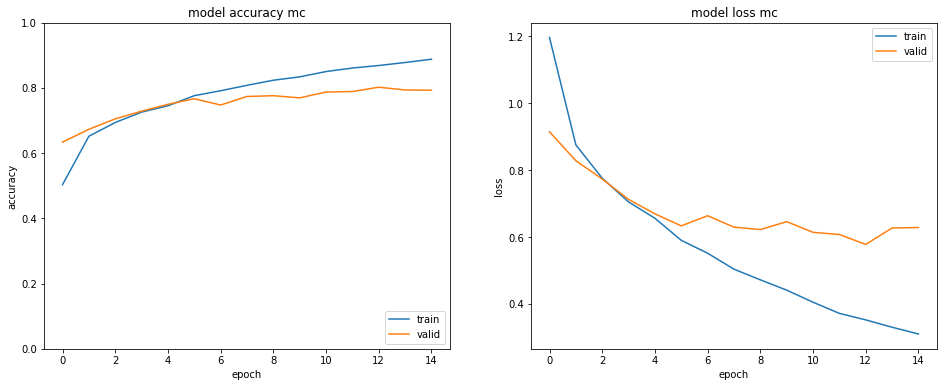

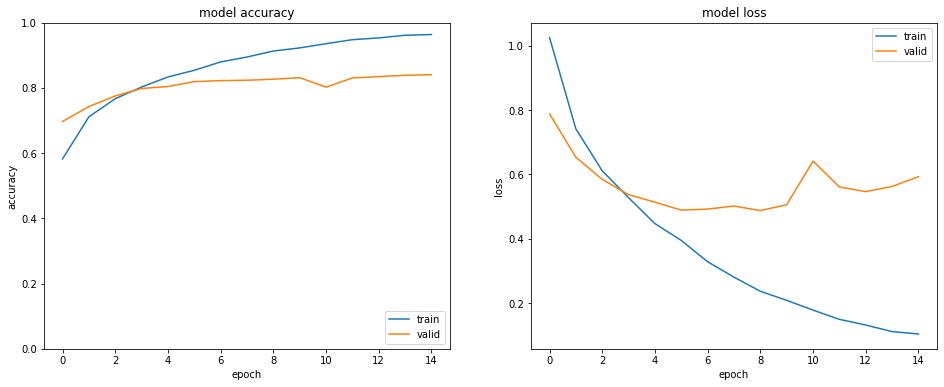

In [23]:
# summarize history for accuracy
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.ylim(0, 1)
plt.title('model accuracy mc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss mc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


#### Prediction

Use both trained model to predict the fist image of the testset for five times, and describe what you observe?  
Do the same for an image that was not used during training.

In [24]:
#predict the same image gives the same result
#here for known label
print(labels[y_test[0]])
for i in range(0,5):
  print(np.round(model.predict(x_test[0].reshape(1,32,32,3)),3))


['airplane']
[[1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]]


In [25]:
#predict the same image does not give the same result
#here for known label
print(labels[y_test[0]])
for i in range(0,5):
  print(np.round(model_mc.predict(x_test[0].reshape(1,32,32,3)),3))


['airplane']
[[0.982 0.    0.017 0.    0.001]]
[[0.984 0.    0.012 0.    0.004]]
[[0.913 0.    0.034 0.004 0.048]]
[[0.982 0.    0.01  0.006 0.001]]
[[0.89  0.    0.005 0.093 0.013]]


In [26]:
#predict the same image does not give the same result
#here for unknown label
print(labels[y_test[2500]])
for i in range(0,5):
  print(np.round(model.predict(x_test[2500].reshape(1,32,32,3)),3))

['dog']
[[0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]]


In [27]:
#predict the same image does not give the same result
#here for unknown label
print(labels[y_test[2501]])
for i in range(0,5):
  print(np.round(model_mc.predict(x_test[2501].reshape(1,32,32,3)),3))


['dog']
[[0.234 0.    0.669 0.044 0.053]]
[[0.007 0.    0.354 0.392 0.247]]
[[0.025 0.    0.044 0.602 0.328]]
[[0.006 0.    0.528 0.196 0.271]]
[[0.011 0.    0.225 0.63  0.134]]


Let's calculate the accuracy for the model without dropout at test time.

In [28]:
preds = model.predict(x_test)
np.average(np.argmax(preds,axis=1)==y_test.flatten())


0.4232

Now we will extract all predicted probabilities for all the test images for both models. In the model with dropout at testtime we will predict each image for multiple times (50) and then take the average of these predicted probabilities for the final prediction. Finally we will use those probabilities as a certainty messure and compare the two models. For the unknown classes we would expect to have a lower certainty than for the known clases.

In [29]:
from tqdm import tqdm_notebook as tqdm
preds_mc=np.zeros((len(x_test),5))
for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds_mc[i]=np.mean(model_mc.predict(multi_img),axis=0)


Let's calculate the accuracy for the model with dropout at test time.

In [30]:
np.average(np.argmax(preds_mc,axis=1)==y_test.flatten())


0.4202

Let's have a closer look whats happening. We plot the probabilities of the classification for each class below. Rememeber that we've trained on the first 5 classes only!

In [0]:
preds_mc_=np.zeros((10,len(x_test)//10,5))
for i in range(0,10):
  preds_mc_[i]=preds_mc[np.where(y_test==i)[0]]

preds_=np.zeros((10,len(x_test)//10,5))
for i in range(0,10):
  preds_[i]=model.predict(x_test[np.where(y_test==i)[0]])


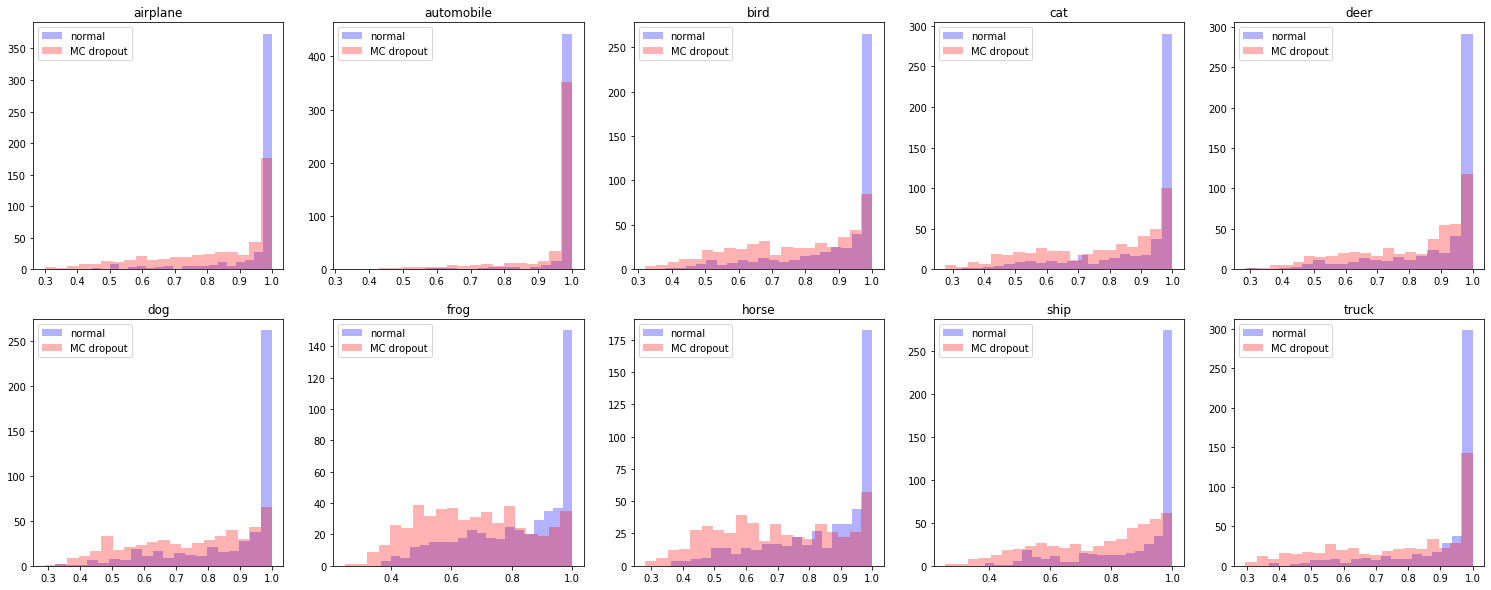

In [32]:
plt.figure(figsize=(26,10))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  plt.hist(np.max(preds_[i],axis=1),alpha=0.3,color="blue",label="normal", bins=20)
  plt.hist(np.max(preds_mc_[i],axis=1),alpha=0.3,color="red",label="MC dropout", bins=20)
  plt.legend()
  plt.title(labels[i])

## What are your conclusions?

Caluclate the accuracy for both approaches when specifiyng a minimal confidence value. How many instances can be classified?

In [33]:
minConfidence = 0.95

preds_thr = preds[np.where(np.max(preds, axis=1)> minConfidence)]
y_test_thr = y_test[np.where(np.max(preds, axis=1)> minConfidence)]
preds_mc_thr = preds_mc[np.where(np.max(preds_mc, axis=1)> minConfidence)]
y_test_mc_thr = y_test[np.where(np.max(preds_mc, axis=1)> minConfidence)]

print ("normal:     ", np.average(np.argmax(preds_thr,axis=1)==y_test_thr.flatten()), '(#', len(y_test_thr),")")
print ("MC dropout: ", np.average(np.argmax(preds_mc_thr,axis=1)==y_test_mc_thr.flatten()), '(#', len(y_test_mc_thr),")")

normal:      0.5460223537146615 (# 3042 )
MC dropout:  0.6770909090909091 (# 1375 )
